In [ ]:
# Clone the repository
!git clone https://github.com/ApoPeri/tensorgator.git
# Navigate to the directory
%cd tensorgator
# Install with the desired package name
!pip install -e . --install-option="--name=tensorgator"

Cloning into 'tensorgator'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 0), reused 31 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 37.29 KiB | 6.21 MiB/s, done.
/content/tensorgator

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option


In [ ]:
#Change runtime top left by ram/disk (to T4)

Starting coverage map generation...
Generating random constellation...
Creating grid of 2701 ground points...
Propagating satellites using CUDA...
Propagation completed in 2.75 seconds
Calculating visibility using CUDA...
Visibility calculation completed in 0.74 seconds
Calculating maximum gaps...


Calculating gaps: 100%|██████████| 2701/2701 [00:06<00:00, 387.86it/s]


Gap calculation completed in 6.97 seconds
Generating map visualization...
Map saved as 'coverage_map.png'


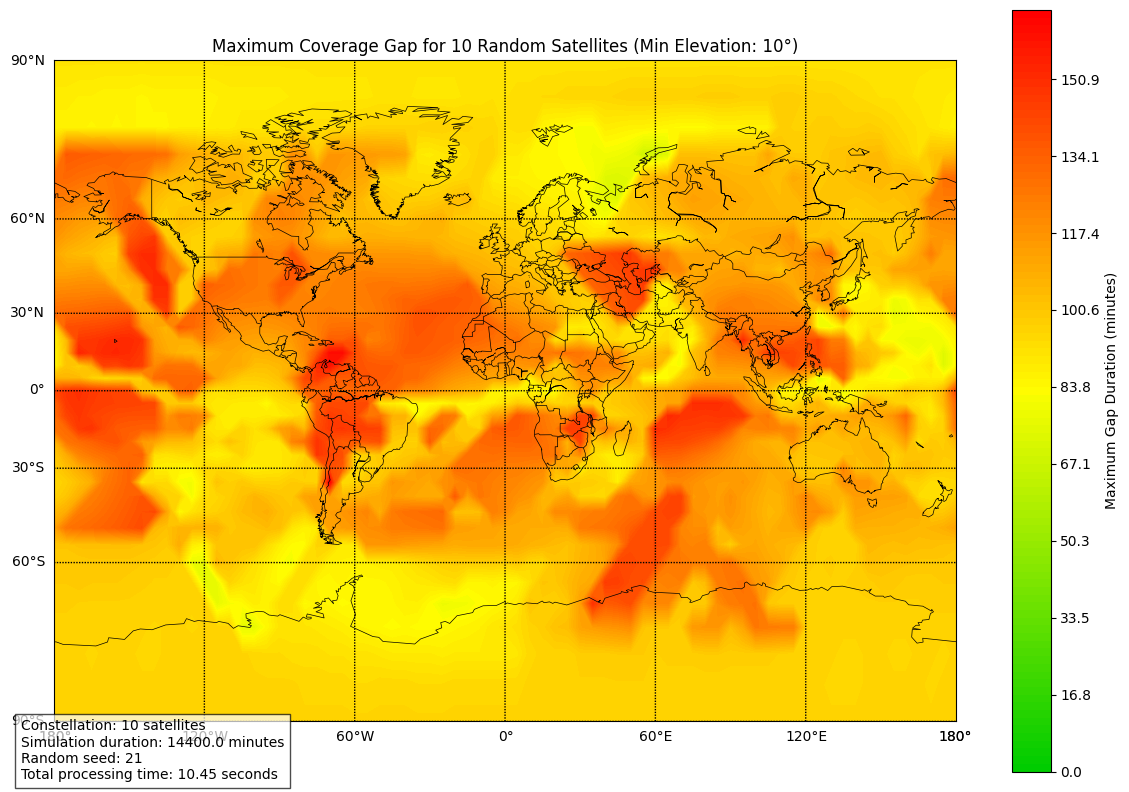

In [ ]:
!pip install basemap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import tensorgator as tg
from mpl_toolkits.basemap import Basemap
import time
from tqdm import tqdm
import math
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

def main():
    """Generate a global coverage map with optimized performance."""
    print("Starting coverage map generation...")

    # Set random seed for reproducibility
    np.random.seed(21)

    # Constants
    RE = tg.RE  # Earth radius in meters

    # Generate 10 random circular orbits (e=0)
    num_sats = 10
    constellation = []

    print("Generating random constellation...")
    for _ in range(num_sats):
        # Random altitude between 500 and 1000 km
        altitude = np.random.uniform(500000, 10000000)
        a = RE + altitude
        e = 0.0  # Circular orbits

        # Random inclination between 0 and 90 degrees
        inc = np.radians(np.random.uniform(0, 90))

        # Random RAAN, argument of perigee, and mean anomaly
        raan = np.radians(np.random.uniform(0, 360))
        argp = np.radians(np.random.uniform(0, 360))
        M0 = np.radians(np.random.uniform(0, 360))

        constellation.append([a, e, inc, raan, argp, M0])

    constellation = np.array(constellation)

    # Create a time span (1 day with 1-minute steps)
    sim_duration = 864000  # 1 day in seconds
    time_step = 60  # 1 minute
    times = np.arange(0, sim_duration, time_step)

    # Create a grid of ground points
    lat_step = 5
    lon_step = 5
    lats = np.arange(-90, 91, lat_step)
    lons = np.arange(-180, 181, lon_step)

    # Create ground points array
    print(f"Creating grid of {len(lats)*len(lons)} ground points...")
    ground_points = []
    for lat in lats:
        for lon in lons:
            ground_points.append(tg.ground_station_ecef(lat, lon))
    ground_points = np.array(ground_points)

    # Minimum elevation angle
    min_elevation_deg = 10
    min_elevation_rad = np.radians(min_elevation_deg)

    # OPTIMIZATION 1: Use CUDA-accelerated propagation
    print("Propagating satellites using CUDA...")
    start_time = time.time()
    positions = tg.satellite_positions(times, constellation, backend='cuda', )
    prop_time = time.time() - start_time
    print(f"Propagation completed in {prop_time:.2f} seconds")

    # OPTIMIZATION 2: Use CUDA-accelerated visibility calculation
    print("Calculating visibility using CUDA...")
    start_time = time.time()
    visibility = tg.calculate_visibility_cuda(positions, ground_points, min_elevation_rad)
    vis_time = time.time() - start_time
    print(f"Visibility calculation completed in {vis_time:.2f} seconds")

    # OPTIMIZATION 3: Use optimized gap calculation
    print("Calculating maximum gaps...")
    start_time = time.time()
    max_gaps = tg.calculate_max_gaps(visibility, time_step)
    gap_time = time.time() - start_time
    print(f"Gap calculation completed in {gap_time:.2f} seconds")

    # Reshape max_gaps to match the grid
    max_gap_grid = max_gaps.reshape(len(lats), len(lons))

    # Create a Basemap visualization
    print("Generating map visualization...")
    plt.figure(figsize=(12, 8))

    # Create a Basemap instance
    m = Basemap(projection='mill', lon_0=0, resolution='c')
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    m.drawparallels(np.arange(-90, 91, 30), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180, 181, 60), labels=[0, 0, 0, 1])

    # Create a mestgrid for plotting
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    x, y = m(lon_grid, lat_grid)

    # Create a custom colormap (green to yellow to red)
    colors = [(0, 0.8, 0), (1, 1, 0), (1, 0, 0)]
    cmap = LinearSegmentedColormap.from_list('GreenYellowRed', colors, N=100)

    # Plot the max gap durations
    max_gap_minutes = max_gap_grid / 60  # Convert to minutes
    levels = np.linspace(0, max(5, np.max(max_gap_minutes)), 100)
    cs = m.contourf(x, y, max_gap_minutes, levels=levels, cmap=cmap)

    # Add a colorbar
    cbar = plt.colorbar(cs, label='Maximum Gap Duration (minutes)')

    # Add title and satellite info
    plt.title(f'Maximum Coverage Gap for {num_sats} Random Satellites (Min Elevation: {min_elevation_deg}°)')

    # Add satellite info in a text box
    total_time = prop_time + vis_time + gap_time
    info_text = f"Constellation: {num_sats} satellites\n"
    info_text += f"Simulation duration: {sim_duration/60:.1f} minutes\n"
    info_text += f"Random seed: 21\n"
    info_text += f"Total processing time: {total_time:.2f} seconds"

    plt.figtext(0.02, 0.02, info_text, bbox=dict(facecolor='white', alpha=0.7))

    # Save and show the plot
    plt.tight_layout()
    plt.savefig('./coverage_map.png', dpi=300)
    print("Map saved as 'coverage_map.png'")
    plt.show()

if __name__ == "__main__":
    main()
